In [1]:
from __future__ import division, absolute_import

import os
import sys
import random

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import h5py
import pickle
import numpy as np
import keras
import pandas as pd
import random
import time

from glob import glob
from keras.models import load_model
from keras import models
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import datetime
from plotnine import *
from itertools import chain

#root
absPath = '/home/angela/padding_EBI/'
sys.path.insert(0, absPath)

from src.Target import Target
from src.processing_activations import *

#para no imprimir warnings chungos
import warnings 
warnings.simplefilter("ignore")

np.random.seed(1)
random.seed(1)
%matplotlib inline

Using TensorFlow backend.


In [2]:
list_paddings = ['ext_padding', 'mid_padding', 'post_padding', 'pre_padding', 
                 'rnd_padding', 'strf_padding',  "zoom_padding"]

#task = 'task1/'
nfolds = 10
folder = 'EC_number/archaea/1conv/64filts_size5/'
nshape = (1, 1000, 26)
nlayer = 2

In [3]:
# def search_model (folder, fold, task, padding):
#     model_path = "".join((absPath, "data/checkpoint/", folder, task, list_paddings[2], "/", "1", "/"))
#     model_file = glob(os.path.join(model_path, "weights-*.hdf5"))[0]
#     return model_file

# def random_prot_idx(folder, task):
#     if task == "task1":
#         file_idcs = os.path.join(absPath, 'data/', folder, 'idcs_split.pickle')
#     else:
#         file_idcs = os.path.join(absPath, 'data/', folder, 'idcs_data_enz.pickle')
#     with open(file_idcs, "rb") as input_file:
#         splitting_sets = pickle.load(input_file)[0]
#     i_train, i_val, i_test = splitting_sets
#     len_test = len(i_test)
#     rnd_index = random.randint(0, len_test-1)
#     protein_index = i_test[rnd_index]
#     return protein_index

# def load_prot(folder, protein_index, padding, labels_label, newshape):
#     data_path = os.path.join(absPath, "data/", folder, "data.h5")
#     f1 = h5py.File(data_path, 'r')
#     prot = f1[padding][protein_index]
#     label_prot = f1[labels_label][protein_index]
#     instarget = Target('AAAAAA')
#     aa_to_int = instarget.predefining_dict()
#     seq_onehot = instarget.int_to_onehot(list(prot), len(aa_to_int))
#     seq_reshaped = np.reshape(seq_onehot, newshape=newshape)
#     return seq_reshaped, label_prot

# def obtain_activations(model_path, n_layer, seq_reshaped):
#     model = load_model(model_path)
#     layer_output = model.layers[n_layer].output
#     activation_model = models.Model(inputs=model.input, outputs=layer_output) 
#     activations = activation_model.predict(seq_reshaped, batch_size=1)
#     shape_act = activations.shape
#     activations_reshaped = np.reshape(activations, newshape=(shape_act[2], shape_act[1]))
#     #print(activations_reshaped.shape)
#     return activations_reshaped

# def activations_to_df(activations, padding, fold):
#     activations_df = pd.DataFrame(activations)
#     activations_df["padding"] = padding
#     activations_df["order"] = list(range(0,activations.shape[0]))
#     activations_df["fold"] = fold
#     #label_prot_noonehot = np.argmax(label_prot, -1)
#     #activations_df["label"] = label_prot_noonehot
#     return activations_df

# def train_pca(list_dfs, ncomps):
#     df_joint = pd.concat(list_dfs, ignore_index=True)
#     x = df_joint.drop(['order', 'padding', 'fold', "enzyme_type",
#                        #, 'label'
#                       ], axis=1).values
#     x = StandardScaler().fit_transform(x)
#     pca = PCA(n_components=ncomps)
#     pca.fit(x)
#     principalComponents = pca.fit_transform(x)
#     principal_df = pd.DataFrame(principalComponents, columns=["PC1", "PC2"])
#     final_df = pd.concat([principal_df, df_joint[['padding']], df_joint[['order']],df_joint[['fold']], 
#                           df_joint[["enzyme_type"]]], 
#                           axis=1)
#     return final_df, pca

def plot_pca(df, pca, type_plot, list_paddings=None):
    fig = plt.figure(figsize = (12,12))
    ax = fig.add_subplot(1,1,1) 
    label_x = " ".join(("Principal Component 1 (", str(round(pca.explained_variance_ratio_[0]*100, 2)), "%)"))
    label_y = " ".join(("Principal Component 2 (", str(round(pca.explained_variance_ratio_[1]*100, 2)), "%)"))
    ax.set_xlabel(label_x, fontsize = 11)
    ax.set_ylabel(label_y, fontsize = 11)
    ax.set_title('PCA of Conv1D (size=5)', fontsize = 14)
    
    if type_plot == "padding":
        colors = ["#FFED6F","#BEBADA","#FB8072","#80B1D3","#FDB462","#B3DE69",
             "#FCCDE5"]
        for padding, color in zip(list_paddings,colors):
            indicesToKeep = df['padding'] == padding
            print(padding, df.loc[indicesToKeep, 'PC1'].shape)
            ax.scatter(df.loc[indicesToKeep, 'PC1']
                   , df.loc[indicesToKeep, 'PC2']
                   , c = color
                   , s = 25,
                      alpha=1)
        ax.legend(list_paddings, title = "Padding type")
        ax.grid()
    elif type_plot == "enzyme_type":
        types_enzymes = list(range(1,8))
        colors = ["#66C2A5", "#FC8D62", "#8DA0CB", "#E78AC3", "#A6D854", "#FFD92F", "#E5C494"]
        for enz_type, color in zip(types_enzymes,colors):
            indicesToKeep = df['enzyme_type'] == enz_type
            #print(enz_type, df.loc[indicesToKeep, 'PC1'].shape)
            ax.scatter(df.loc[indicesToKeep, 'PC1']
               , df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 25,
                  alpha=0.8)
        ax.legend(types_enzymes, title = "Enzyme type")
        ax.grid()
        
    elif type_plot == "enz_type1":
        types_enzymes = [0,1]
        colors = ["#6CB89E", "#F38E73"]
        for enz_type, color in zip(types_enzymes, colors):
            indicesToKeep = df['enzyme_type'] == enz_type
            #print(enz_type, df.loc[indicesToKeep, 'PC1'].shape)
            ax.scatter(df.loc[indicesToKeep, 'PC1']
               , df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 25,
                  alpha=0.8)
        ax.legend(types_enzymes, title = "Enzyme type")
        ax.grid()
    else:
        ax.scatter(df.loc[:, 'PC1'], df.loc[:, 'PC2'], 
                   c=df.loc[:, 'sequence_length'], edgecolor='none', alpha=0.7)
        im = plt.gca().get_children()[0]
        cax = fig.add_axes([1,0.1,0.03,0.8]) 
        clb=fig.colorbar(im, cax=cax)  
        clb.ax.set_title("Protein sequence length")
        ax.grid()
    
# #function to select proteins of the test set with an specific enzimatic label
# def find_prot_labeled(folder, enz_label, quant=2, task = "task2", labels_label = "labels_task2"):
#     data_path = os.path.join(absPath, "data/", folder, "data.h5")
#     f1 = h5py.File(data_path, 'r')
#     indices_enzymes = []
#     while len(indices_enzymes)<quant:
#         idx = random_prot_idx(folder, task)
#         if task == "task2":
#             label_prot = np.argmax(f1[labels_label][idx]) + 1
#         else:
#             label_prot = np.argmax(f1[labels_label][idx])
#         if label_prot == enz_label:
#             indices_enzymes.append(idx)
#     return indices_enzymes

# def load_prot_labeled(folder, padding, newshape, enz_label, idx):
#     data_path = os.path.join(absPath, "data/", folder, "data.h5")
#     f1 = h5py.File(data_path, 'r')
#     instarget = Target('AAAAAA')
#     aa_to_int = instarget.predefining_dict()
#     prot = f1[padding][idx]
#     seq_onehot = instarget.int_to_onehot(list(prot), len(aa_to_int))
#     seq_reshaped = np.reshape(seq_onehot, newshape=newshape)
#     return seq_reshaped

# def plot_pca_per_padding(final_df, pca, plot_by = "factor(enzyme_type)"):
#     p = (ggplot(final_df, aes(x="PC1", y="PC2", color=plot_by))
#     + geom_jitter(alpha=0.8, size=1)
#      #+ scale_color_brewer(palette="Set2", type='qual', name="enzyme type")
#     + theme_bw()
#     + facet_wrap("~padding", nrow=4, ncol=2)
#     +theme(figure_size=(8,8), axis_text_y =element_text(size=9),
#                 legend_text=element_text(size=12), strip_text_x = element_text(size=9), 
#                strip_text_y = element_text(size=9), plot_title = element_text(size=14), 
#            #axis_title_y = element_blank(),
#                axis_title_x = element_text(size = 11), legend_key_size = 12,
#            axis_title_y = element_text(size = 11),
#                 legend_box="horizontal")
#     +ggtitle('PCA of Conv1D (size=5)')
#     + xlab(" ".join(("Principal Component 1 (", str(round(pca.explained_variance_ratio_[0]*100, 2)), "%)")))
#     +ylab(" ".join(("Principal Component 2 (", str(round(pca.explained_variance_ratio_[1]*100, 2)), "%)"))))
    
#     if plot_by == "factor(enzyme_type)":
#         q = p + scale_color_brewer(palette="Set2", type='qual', name="enzyme type")
#     else:
#         q = p
#     return q

# def density_facet(final_df, pca):
#     p = (ggplot(final_df, aes(x="PC1", y="PC2", fill="factor(enzyme_type)"))
#     #+ geom_density_2d(aes(fill="..level..", levels=10, alpha=0.8))
#     # +geom_point()
#      + stat_density_2d(aes(alpha="stat(level)"), color="black", geom="polygon")
#      + scale_fill_brewer(palette="Set2", type='qual', name="enzyme type")
#      #+ scale_fill_gradient(low = "")
#     + theme_bw()
#      + facet_grid("enzyme_type~padding")
#     #+ facet_grid("~padding", nrow=4, ncol=2)
#     +theme(figure_size=(10,10), axis_text_y =element_text(size=9),
#                 legend_text=element_text(size=12), strip_text_x = element_text(size=9), 
#        #axis_text_x = element_blank(),
#                strip_text_y = element_text(size=9), plot_title = element_text(size=14), 
#            #axis_title_y = element_blank(),
#                axis_title_x = element_text(size = 11), legend_key_size = 12,
#            axis_title_y = element_text(size = 11),
#        #legend_position="bottom", 
#                 legend_box="horizontal")
#     +ggtitle('PCA of Conv1D (size=5)')
#     + xlab(" ".join(("Principal Component 1 (", str(round(pca.explained_variance_ratio_[0]*100, 2)), "%)")))
#     +ylab(" ".join(("Principal Component 2 (", str(round(pca.explained_variance_ratio_[1]*100, 2)), "%)"))))
#     return p

# #pintar loadings
# def plot_loadings(score,coeff,labels=None):
#     xs = score[:,0]
#     ys = score[:,1]
#     n = coeff.shape[0]
#     scalex = 1.0/(xs.max() - xs.min())
#     scaley = 1.0/(ys.max() - ys.min())
#     plt.figure(figsize=(10,10))
#     #plt.scatter(xs * scalex,ys * scaley, 
#     #           # c = y
#     #           )
#     for i in range(n):
#         plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
#         if labels is None:
#             plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
#         else:
#             plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
#     plt.xlim(-0.1,0.1)
#     plt.ylim(-0.1,0.1)
#     plt.xlabel("PC{}".format(1))
#     plt.ylabel("PC{}".format(2))
#     plt.grid()
    
# def int_to_aa(x_int, diccionario):
#     """Translate a list of integer numbers to a sequence of amino acids, given a dictionary"""
#     result = []   
#     for j in x_int:
#         if j == 0:
#             result.append("0")
#         else:
#             result.append(list(diccionario.keys())[list(diccionario.values()).index(j)])
#     return result

# def load_prot_aminoacids(folder, protein_index, padding, labels_label):
#     data_path = os.path.join(absPath, "data/", folder, "data.h5")
#     f1 = h5py.File(data_path, 'r')
#     prot = f1[padding][protein_index]
#     instarget = Target('AAAAAA')
#     seq_int = f1[padding][protein_index]
#     aa_to_int = instarget.predefining_dict()
#     sequence_aas = int_to_aa(seq_int, aa_to_int)
#     label_prot = f1[labels_label][protein_index]
#     return sequence_aas, label_prot

# def add_sequences_length(final_df, df_indices):
#     len_len_seq = int((len(final_df)/7)/2)
#     print(len_len_seq)
#     lista_lengths = []
#     for idx, row in df_indices.iterrows():
#         len_seq = row["len_seq"]
#         lista_lengths.append([len_seq]*len_len_seq)
#     lista_lengths_unnested = [item for sublist in lista_lengths for item in sublist]
#     print(len(lista_lengths_unnested))
#     print(final_df.info())
#     final_df["sequence_length"] = lista_lengths_unnested
#     return final_df

# def myplot(score,coeff,labels=None):
#     plt.figure(figsize=(10,10))
#     xs = score[:,0]
#     ys = score[:,1]
#     n = coeff.shape[0]
#     scalex = 1.0/(xs.max() - xs.min())
#     scaley = 1.0/(ys.max() - ys.min())
#     #plt.scatter(xs * scalex,ys * scaley, 
#     #            #c = y
#     #           )
#     for i in range(n):
#         plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
#         if labels is None:
#             plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
#         else:
#             plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
#     plt.xlim(-0.1,0.1)
#     plt.ylim(-0.1,0.1)
#     plt.xlabel("PC{}".format(1))
#     plt.ylabel("PC{}".format(2))
#     plt.grid()

def saving_activations_plot(packagee, type_plot, folder, task, p=None):
    if packagee == "plt":
        extension = ".png"
        file_fig = ''.join(string for string in [absPath,'data/results/', folder, task, 'pcaActivations_',
                                         type_plot, extension])
        plt.savefig(file_fig)
    else:
        extension = ".pdf"
        path_fig = ''.join(string for string in [absPath,'data/results/', folder, task])
        file_fig = ''.join(string for string in ['pcaActivations_', type_plot, extension])
        p.save(path = path_fig, format = 'pdf', dpi=300, filename=file_fig)
        
def find_prot_labeled(folder, enz_label, quant=2, task = "task2", labels_label = "labels_task2"):
    data_path = os.path.join(absPath, "data/", folder, "data.h5")
    f1 = h5py.File(data_path, 'r')
    indices_enzymes = []
    while len(indices_enzymes)<quant:
        idx = random_prot_idx(folder, task)
        if task == "task2":
            label_prot = np.argmax(f1[labels_label][idx]) + 1
        else:
            label_prot = np.argmax(f1[labels_label][idx])
        if label_prot == enz_label:
            indices_enzymes.append(idx)
    return indices_enzymes

In [4]:
prots_pca = []
list_indices_enzymes = []
for enz_label in range(1,8):
    indices_enzymes = find_prot_labeled(folder, enz_label)
    print(indices_enzymes, enz_label)
    list_indices_enzymes.append((indices_enzymes, enz_label))
    for idx,i in enumerate(indices_enzymes):
        for padding in list_paddings:
            seq = load_prot_labeled(folder, padding, nshape, enz_label, i)
            prots_pca.append((seq,enz_label, padding))
            #print(enz_label, "prot", idx)

[17828, 18097] 1
[18234, 3639] 2
[18624, 10859] 3
[10809, 5232] 4
[6482, 6602] 5
[8546, 16129] 6
[11613, 16508] 7


## Task 2

In [5]:
task = 'task2/'
fold = 5

In [6]:
#Define list of dataframes
lista_dfs = []
for tup in prots_pca:
    model_type = tup[2]
    enz_type = tup[1]
    prot = tup[0]
    #print("Model type: ", model_type, "enzyme type", enz_type)
    model = search_model(folder, str(fold), task, model_type)
    #writing log file 
    print('Model type: %s \n' % model_type)
    print('Enzyme type: %s \n' % enz_type)
    formatted_time = datetime.datetime.now()
    print('Starting time: %s \n' % formatted_time)
    activations = obtain_activations(model, nlayer, prot)
    act_df = activations_to_df(activations, model_type, fold)
    act_df["enzyme_type"] = tup[1]
    formatted_endtime = datetime.datetime.now()
    print('Finishing time: %s \n' % formatted_endtime)
    lista_dfs.append(act_df)

Model type: ext_padding 

Enzyme type: 1 

Starting time: 2019-11-11 12:18:48.223805 

Finishing time: 2019-11-11 12:18:49.303938 

Model type: mid_padding 

Enzyme type: 1 

Starting time: 2019-11-11 12:18:49.331311 

Finishing time: 2019-11-11 12:18:50.249514 

Model type: post_padding 

Enzyme type: 1 

Starting time: 2019-11-11 12:18:50.283746 

Finishing time: 2019-11-11 12:18:51.172086 

Model type: pre_padding 

Enzyme type: 1 

Starting time: 2019-11-11 12:18:51.172958 

Finishing time: 2019-11-11 12:18:52.243319 

Model type: rnd_padding 

Enzyme type: 1 

Starting time: 2019-11-11 12:18:52.244332 

Finishing time: 2019-11-11 12:18:53.394085 

Model type: strf_padding 

Enzyme type: 1 

Starting time: 2019-11-11 12:18:53.394910 

Finishing time: 2019-11-11 12:18:54.776589 

Model type: zoom_padding 

Enzyme type: 1 

Starting time: 2019-11-11 12:18:54.793381 

Finishing time: 2019-11-11 12:18:56.135758 

Model type: ext_padding 

Enzyme type: 1 

Starting time: 2019-11-11 12:1

Finishing time: 2019-11-11 12:23:32.141555 

Model type: ext_padding 

Enzyme type: 5 

Starting time: 2019-11-11 12:23:32.142302 

Finishing time: 2019-11-11 12:23:41.060837 

Model type: mid_padding 

Enzyme type: 5 

Starting time: 2019-11-11 12:23:41.061059 

Finishing time: 2019-11-11 12:23:50.142709 

Model type: post_padding 

Enzyme type: 5 

Starting time: 2019-11-11 12:23:50.142942 

Finishing time: 2019-11-11 12:23:59.409289 

Model type: pre_padding 

Enzyme type: 5 

Starting time: 2019-11-11 12:23:59.409531 

Finishing time: 2019-11-11 12:24:08.884470 

Model type: rnd_padding 

Enzyme type: 5 

Starting time: 2019-11-11 12:24:08.885066 

Finishing time: 2019-11-11 12:24:18.438691 

Model type: strf_padding 

Enzyme type: 5 

Starting time: 2019-11-11 12:24:18.439308 

Finishing time: 2019-11-11 12:24:28.180471 

Model type: zoom_padding 

Enzyme type: 5 

Starting time: 2019-11-11 12:24:28.180675 

Finishing time: 2019-11-11 12:24:38.081908 

Model type: ext_padding 

En

In [7]:
#investigar dfs

len(lista_dfs)

98

In [8]:
lista_dfs[0].shape

(64, 1004)

In [9]:
# ha tardado un huevo en ejecutarse asi que deberia guardarlo
filename = "activations_enzymeType_1fold.pickle"
pickle_path = "".join((absPath, "data/results/", folder, task, filename))

with open(pickle_path, 'wb') as handle:
    pickle.dump(lista_dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
lista_dfs[0].columns

Index([            0,             1,             2,             3,
                   4,             5,             6,             7,
                   8,             9,
       ...
                 994,           995,           996,           997,
                 998,           999,     'padding',       'order',
              'fold', 'enzyme_type'],
      dtype='object', length=1004)

In [11]:
final_df, pca = train_pca(lista_dfs, 2)

In [12]:
final_df.shape

(6272, 6)

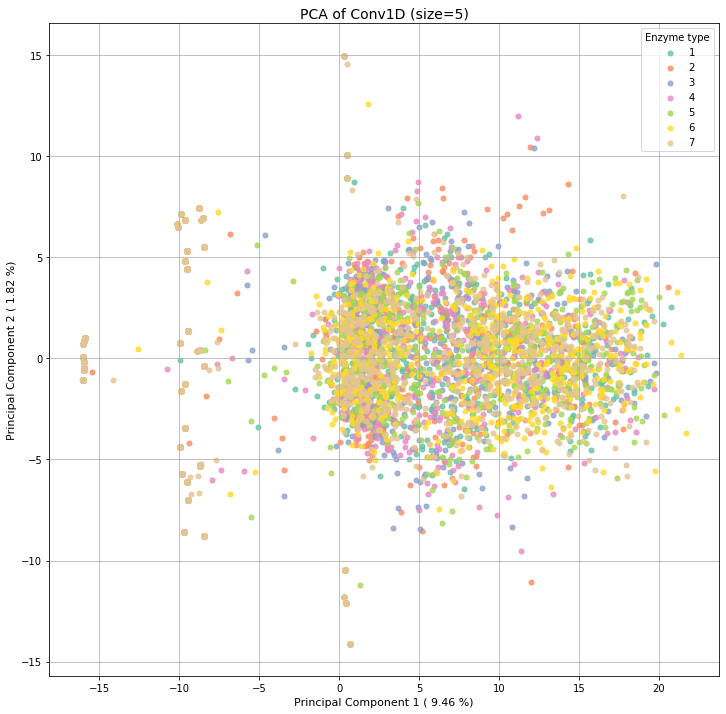

In [13]:
plot_pca(final_df, pca, "enzyme_type")
saving_activations_plot("plt", "2protsPerType_enzType_1fold", folder, task, p=None)

ext_padding (896,)
mid_padding (896,)
post_padding (896,)
pre_padding (896,)
rnd_padding (896,)
strf_padding (896,)
zoom_padding (896,)


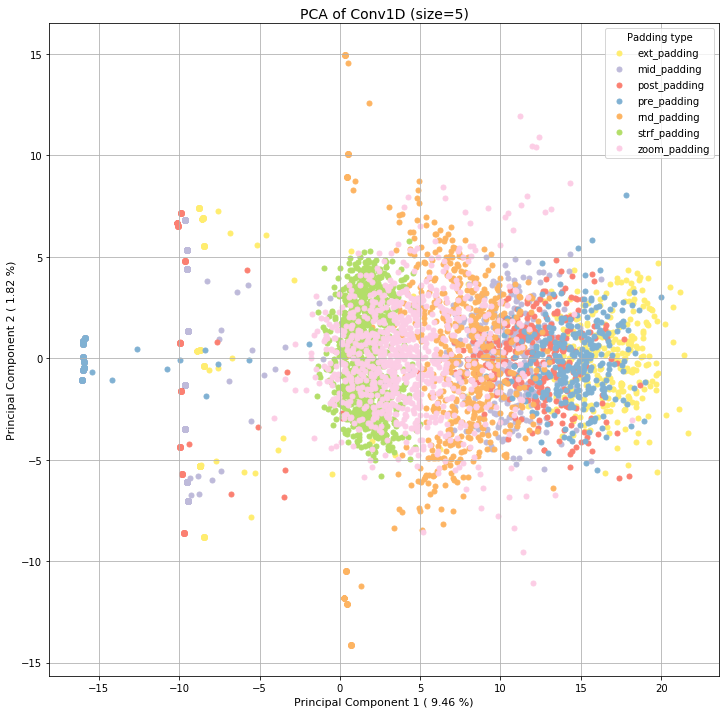

In [14]:
plot_pca(final_df, pca, "padding", list_paddings)
saving_activations_plot("plt", "2protsPerType_padding_1fold", folder, task, p=None)

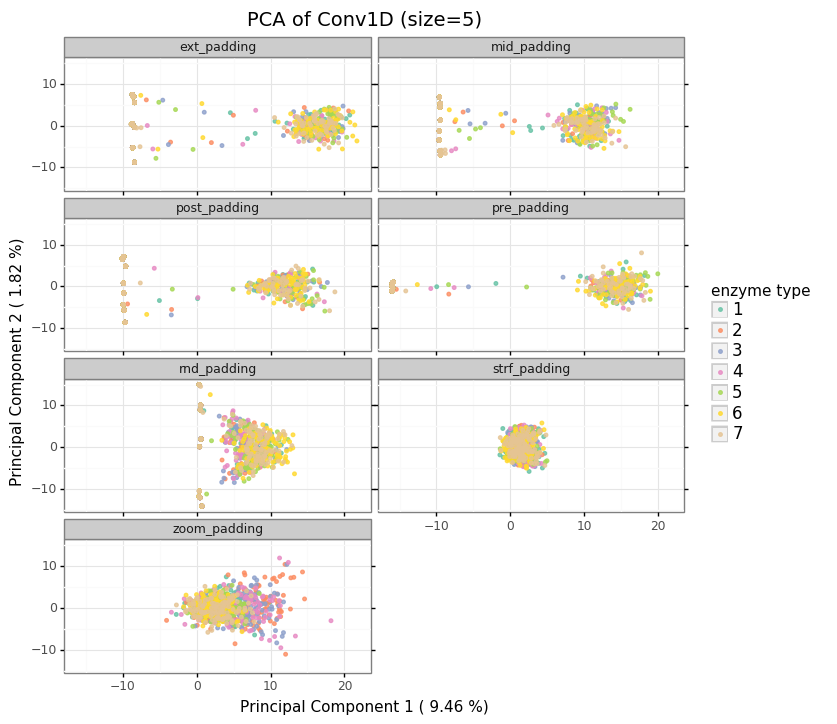

<ggplot: (8753635275577)>

In [15]:
p = plot_pca_per_padding(final_df, pca)
saving_activations_plot("ggplot", "2protsPerType_facetPerPadding_1fold", folder, task, p=p)
p

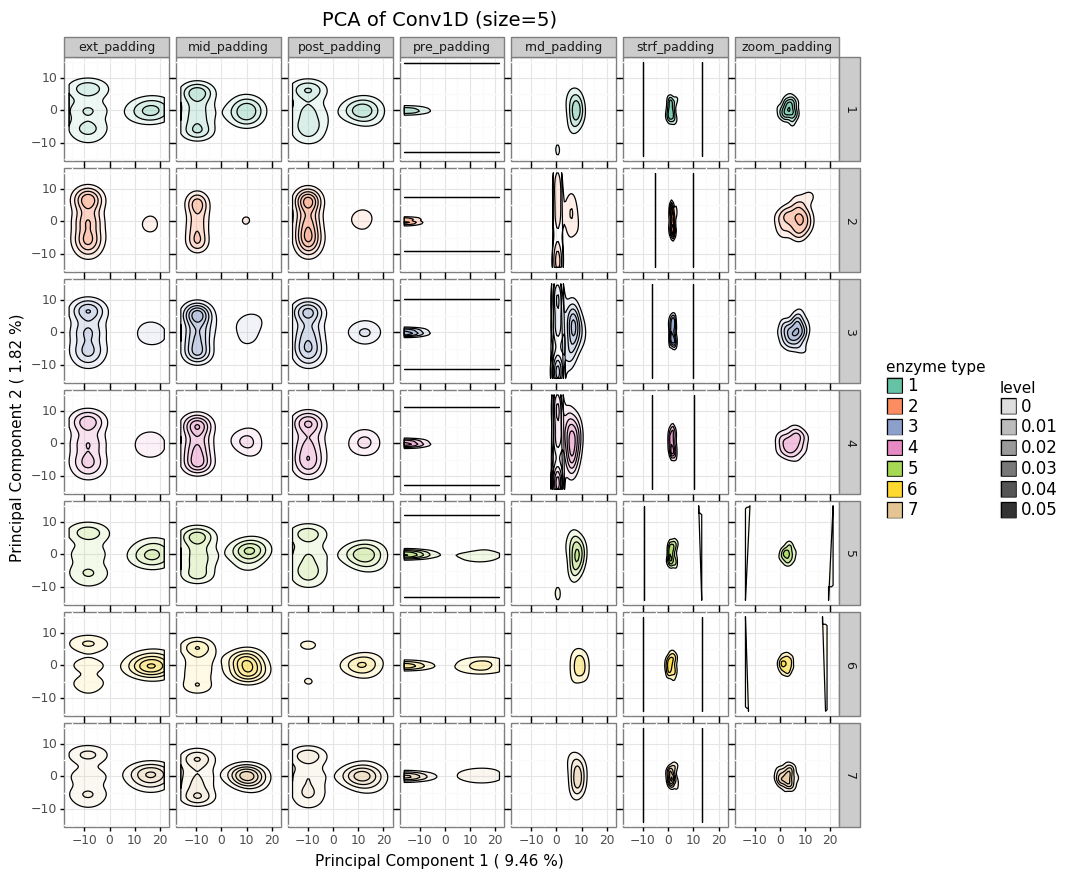

<ggplot: (8753625504944)>

In [16]:
q = density_facet(final_df, pca)
saving_activations_plot("ggplot", "2protsPerType_densityFacet_1fold", folder, task, p=q)
q

In [17]:
#esto se deberia hacer automaticamente
df_indices = pd.DataFrame(columns=["indices", "enz_type", "len_seq"])
df_indices["indices"] = list(chain(*[i[0] for i in list_indices_enzymes]))
df_indices["enz_type"] = [1,1,2,2,3,3,4,4,5,5,6,6,7,7]

In [18]:
padding = "post_padding"
for idx, row in df_indices.iterrows():
    prot_idx = row["indices"]
    prot, label = load_prot_aminoacids(folder, prot_idx, padding, "labels_task2")
    len_seq = len([idx for idx, i in enumerate(prot) if i != '0'])
    df_indices.loc[idx, "len_seq"] = len_seq

In [19]:
final_df = add_sequences_length(final_df, df_indices)

448
6272
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6272 entries, 0 to 6271
Data columns (total 6 columns):
PC1            6272 non-null float32
PC2            6272 non-null float32
padding        6272 non-null object
order          6272 non-null int64
fold           6272 non-null int64
enzyme_type    6272 non-null int64
dtypes: float32(2), int64(3), object(1)
memory usage: 245.1+ KB
None


In [20]:
final_df.head()

,PC1,PC2,padding,order,fold,enzyme_type,sequence_length
0,-8.604600,6.849868,ext_padding,0,5,1,335
1,-8.736626,7.433473,ext_padding,1,5,1,335
2,-8.442528,5.523083,ext_padding,2,5,1,335
3,-8.460973,-0.364806,ext_padding,3,5,1,335
4,-8.680471,-5.285091,ext_padding,4,5,1,335


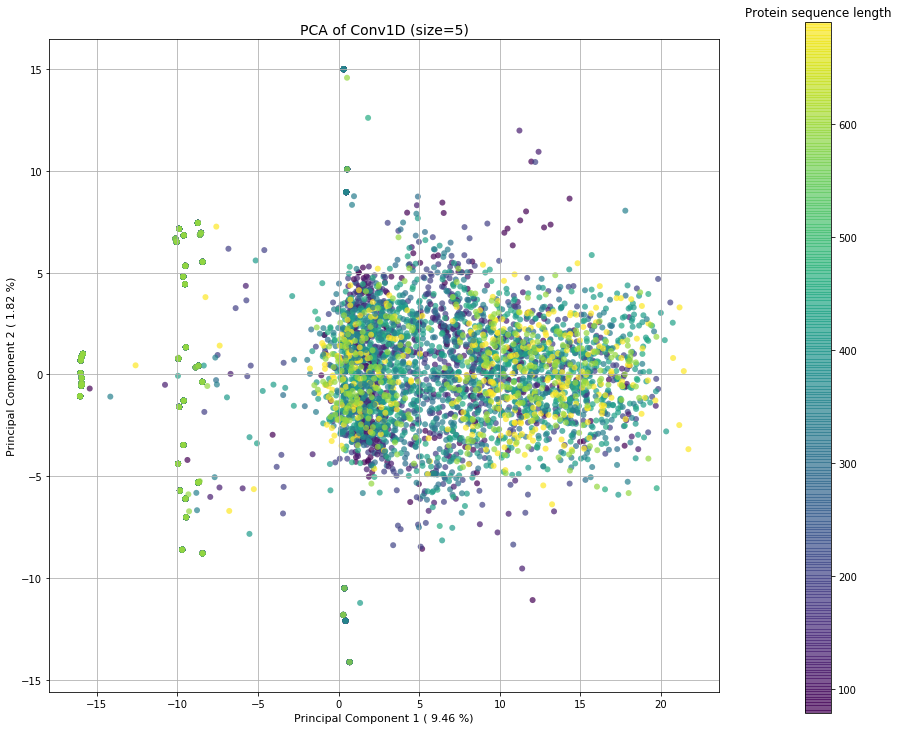

In [21]:
plot_pca(final_df, pca, "seq_len", None)
saving_activations_plot("plt", "2protsPerType_sequenceLenght_1fold", folder, task)

In [22]:
r = plot_pca_per_padding(final_df, pca, "sequence_length")
saving_activations_plot("ggplot", "2protsPerType_facetPerSequence", folder, task, p=r)

In [23]:
final_df.head()

,PC1,PC2,padding,order,fold,enzyme_type,sequence_length
0,-8.604600,6.849868,ext_padding,0,5,1,335
1,-8.736626,7.433473,ext_padding,1,5,1,335
2,-8.442528,5.523083,ext_padding,2,5,1,335
3,-8.460973,-0.364806,ext_padding,3,5,1,335
4,-8.680471,-5.285091,ext_padding,4,5,1,335


In [24]:
#cambiar respecto a la nueva funcion de train_pca
df_joint = pd.concat(lista_dfs, ignore_index=True)
x = df_joint.drop(['order', 'padding', 'fold', "enzyme_type",
                       #, 'label'
                      ], axis=1).values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
pca.fit(x)
principalComponents = pca.fit_transform(x)

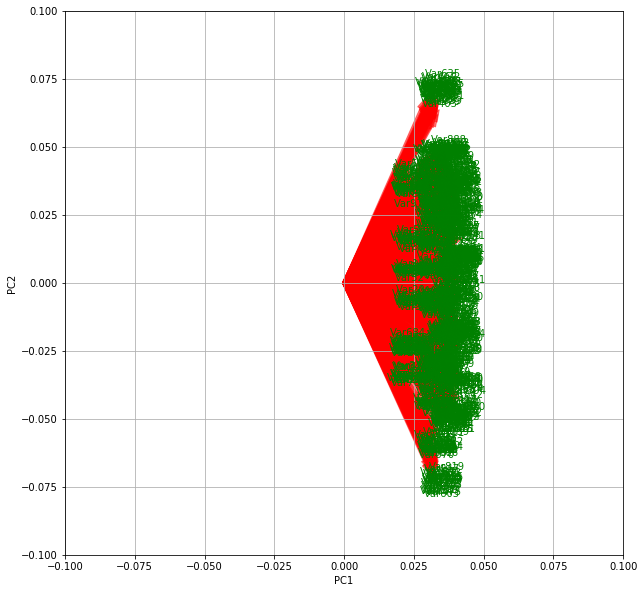

In [25]:
myplot(principalComponents, np.transpose(pca.components_))
saving_activations_plot("plt", "2protsPerType_biplot_1fold", folder, task)

In [26]:
# guardamos final_df en un csv
task = "task2/"
filename = "pca_1fold.csv"
pickle_path = "".join((absPath, "data/results/", folder, task, filename))

#with open(pickle_path, 'wb') as handle:
#    pickle.dump(final_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

final_df.to_csv(pickle_path)

In [ ]:
#hacer plot como el de las densidades pero con la longitud

## Task 1

In [ ]:
task = "task1/"

In [ ]:
#mismo pca para enzima/no enzima

In [ ]:
#coger al azar 7 enzimas y 7 no enzimas para comparar
prots_pca_task1 = []
list_indices_enzymes_task1 = []
for enz_label in [0,1]:
    indices_enzymes_task1 = find_prot_labeled(folder, enz_label, 7, "task1", "labels_task1")
    print(indices_enzymes_task1, enz_label)
    list_indices_enzymes_task1.append((indices_enzymes_task1, enz_label))
    for idx,i in enumerate(indices_enzymes_task1):
        for padding in list_paddings:
            seq = load_prot_labeled(folder, padding, nshape, enz_label, i)
            prots_pca_task1.append((seq, enz_label, padding))
            #print(enz_label, "prot", idx)

[2495, 12715, 4667, 17906, 4169, 17274, 8855] 0
[18562, 4019, 18981, 6642, 1886, 8792, 10066] 1


In [ ]:
# ha tardado un huevo en ejecutarse asi que deberia guardarlo
#filename = "activations_enzymeType_1fold.pickle"
#pickle_path = "".join((absPath, "data/results/", task, filename))

#with open(pickle_path, 'wb') as handle:
#    pickle.dump(lista_dfs_task1, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#Define list of dataframes
fold = 5
lista_dfs_task1 = []
for tup in prots_pca_task1:
    model_type = tup[2]
    enz_type = tup[1]
    prot = tup[0]
    #print("Model type: ", model_type, "enzyme type", enz_type)
    model = search_model(folder, str(fold), task, model_type)
    #writing log file 
    print('Model type: %s \n' % model_type)
    print('Enzyme type: %s \n' % enz_type)
    formatted_time = datetime.datetime.now()
    print('Starting time: %s \n' % formatted_time)
    activations = obtain_activations(model, nlayer, prot)
    act_df = activations_to_df(activations, model_type, fold)
    act_df["enzyme_type"] = tup[1]
    formatted_endtime = datetime.datetime.now()
    print('Finishing time: %s \n' % formatted_endtime)
    lista_dfs_task1.append(act_df)

Model type: ext_padding 

Enzyme type: 0 

Starting time: 2019-11-11 12:31:24.302695 

Finishing time: 2019-11-11 12:31:39.161074 

Model type: mid_padding 

Enzyme type: 0 

Starting time: 2019-11-11 12:31:39.185452 

Finishing time: 2019-11-11 12:31:54.190015 

Model type: post_padding 

Enzyme type: 0 

Starting time: 2019-11-11 12:31:54.198061 

Finishing time: 2019-11-11 12:32:09.420028 

Model type: pre_padding 

Enzyme type: 0 

Starting time: 2019-11-11 12:32:09.429352 

Finishing time: 2019-11-11 12:32:25.734787 

Model type: rnd_padding 

Enzyme type: 0 

Starting time: 2019-11-11 12:32:25.750513 

Finishing time: 2019-11-11 12:32:41.348374 

Model type: strf_padding 

Enzyme type: 0 

Starting time: 2019-11-11 12:32:41.355784 

Finishing time: 2019-11-11 12:32:57.183447 

Model type: zoom_padding 

Enzyme type: 0 

Starting time: 2019-11-11 12:32:57.202215 

Finishing time: 2019-11-11 12:33:13.297889 

Model type: ext_padding 

Enzyme type: 0 

Starting time: 2019-11-11 12:3

Finishing time: 2019-11-11 12:54:34.711769 

Model type: ext_padding 

Enzyme type: 1 

Starting time: 2019-11-11 12:54:34.711976 

Finishing time: 2019-11-11 12:55:04.817205 

Model type: mid_padding 

Enzyme type: 1 

Starting time: 2019-11-11 12:55:04.817625 

Finishing time: 2019-11-11 12:55:35.193725 

Model type: post_padding 

Enzyme type: 1 

Starting time: 2019-11-11 12:55:35.194197 

Finishing time: 2019-11-11 12:56:05.726231 

Model type: pre_padding 

Enzyme type: 1 

Starting time: 2019-11-11 12:56:05.726910 

Finishing time: 2019-11-11 12:56:36.582745 

Model type: rnd_padding 

Enzyme type: 1 

Starting time: 2019-11-11 12:56:36.583512 

Finishing time: 2019-11-11 12:57:07.743783 

Model type: strf_padding 

Enzyme type: 1 

Starting time: 2019-11-11 12:57:07.744002 

Finishing time: 2019-11-11 12:57:39.093253 

Model type: zoom_padding 

Enzyme type: 1 

Starting time: 2019-11-11 12:57:39.093466 

Finishing time: 2019-11-11 12:58:10.751325 

Model type: ext_padding 

En

In [ ]:
# ha tardado un huevo en ejecutarse asi que deberia guardarlo
filename = "activations_enzymeType_1fold.pickle"
pickle_path = "".join((absPath, "data/results/", folder, task, filename))

with open(pickle_path, 'wb') as handle:
    pickle.dump(lista_dfs_task1, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
final_df_task1, pca_task1 = train_pca(lista_dfs_task1, 2)

In [ ]:
# guardamos final_df en un csv
filename = "pca_1fold.csv"
pickle_path = "".join((absPath, "data/results/", folder, task, filename))

#with open(pickle_path, 'wb') as handle:
#    pickle.dump(final_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

final_df_task1.to_csv(pickle_path)

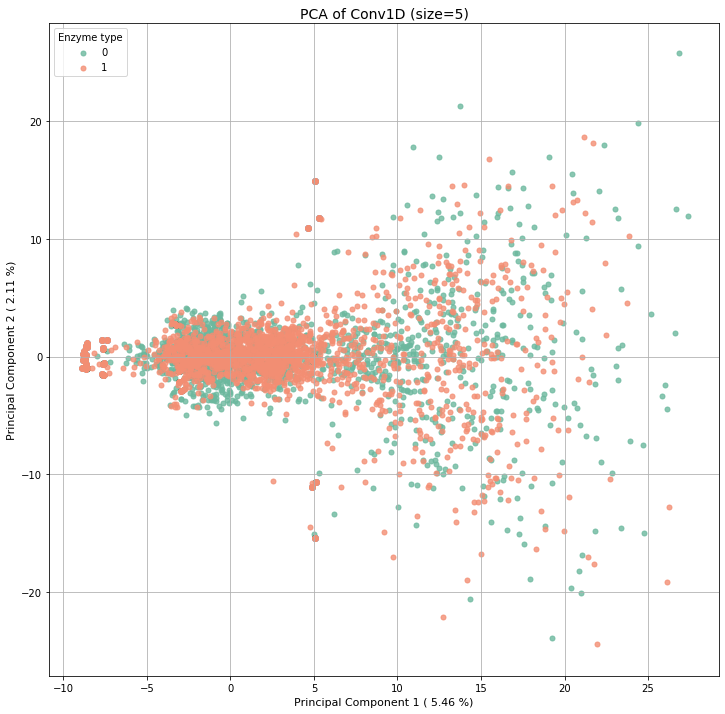

In [ ]:
plot_pca(final_df_task1, pca_task1, "enz_type1", list_paddings)
saving_activations_plot("plt", "7protsPerType_enzType_1fold", folder, task, p=None)

In [ ]:
p = plot_pca_per_padding(final_df_task1, pca_task1, plot_by = "factor(enzyme_type)")
saving_activations_plot("ggplot", "7protsPerType_facetPerPadding", folder, task, p=p)

ext_padding (896,)
mid_padding (896,)
post_padding (896,)
pre_padding (896,)
rnd_padding (896,)
strf_padding (896,)
zoom_padding (896,)


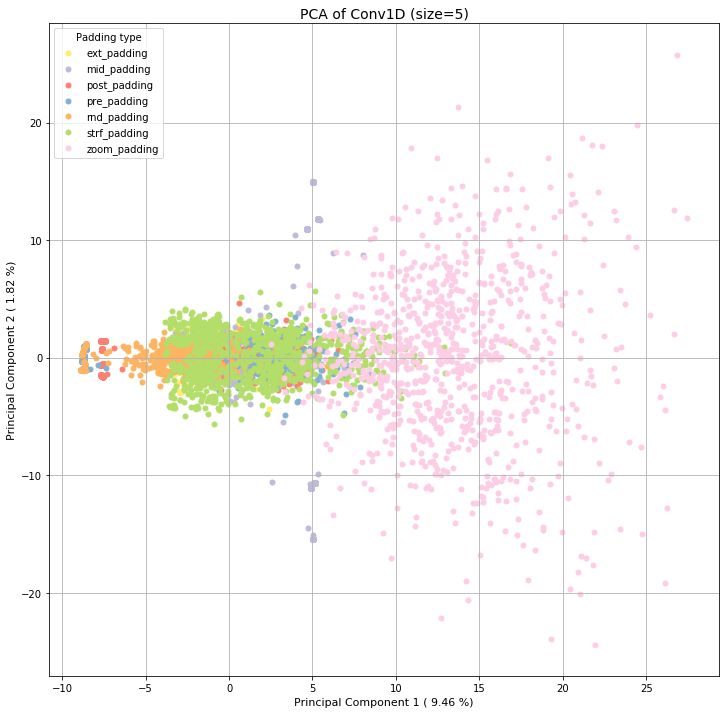

In [ ]:
plot_pca(final_df_task1, pca, "padding", list_paddings)
saving_activations_plot("plt", "7protsPerType_padding_1fold", folder, task, p=p)

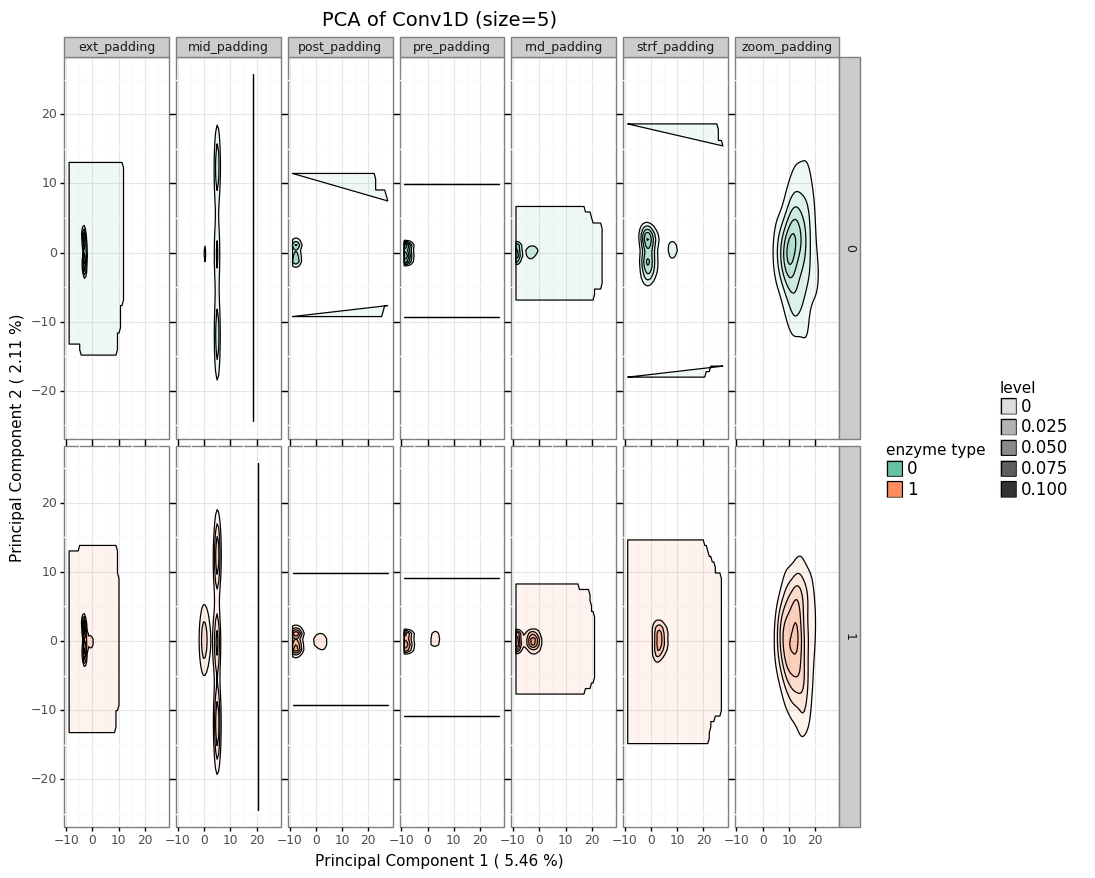

<ggplot: (-9223363283306098530)>

In [ ]:
r = density_facet(final_df_task1, pca_task1)
saving_activations_plot("ggplot", "7protsPerType_densityFacet_1fold", folder, task, p=r)
r

## bi_lstm (en lugar de 1_conv)

## Task 2

In [ ]:
task = 'task2/'
fold = 5
nlayer = 2
folder = 'EC_number/archaea/rnn_conv/256rnn/'

In [ ]:
#model_path = search_model(folder, str(fold), task, model_type)
#model = load_model(model_path)
#model.summary()

In [ ]:
#model.layers[2]

In [ ]:
#Define list of dataframes
lista_dfs = []
for tup in prots_pca:
    model_type = tup[2]
    enz_type = tup[1]
    prot = tup[0]
    #print("Model type: ", model_type, "enzyme type", enz_type)
    model = search_model(folder, str(fold), task, model_type)
    #writing log file 
    print('Model type: %s \n' % model_type)
    print('Enzyme type: %s \n' % enz_type)
    formatted_time = datetime.datetime.now()
    print('Starting time: %s \n' % formatted_time)
    activations = obtain_activations(model, nlayer, prot)
    act_df = activations_to_df(activations, model_type, fold)
    act_df["enzyme_type"] = tup[1]
    formatted_endtime = datetime.datetime.now()
    print('Finishing time: %s \n' % formatted_endtime)
    lista_dfs.append(act_df)

Model type: ext_padding 

Enzyme type: 1 

Starting time: 2019-11-11 13:15:16.977385 

Finishing time: 2019-11-11 13:16:01.296663 

Model type: mid_padding 

Enzyme type: 1 

Starting time: 2019-11-11 13:16:01.316836 

Finishing time: 2019-11-11 13:16:46.614013 

Model type: post_padding 

Enzyme type: 1 

Starting time: 2019-11-11 13:16:46.629615 

Finishing time: 2019-11-11 13:17:34.666970 

Model type: pre_padding 

Enzyme type: 1 

Starting time: 2019-11-11 13:17:34.684296 

Finishing time: 2019-11-11 13:18:21.670976 

Model type: rnd_padding 

Enzyme type: 1 

Starting time: 2019-11-11 13:18:21.690567 

Finishing time: 2019-11-11 13:19:09.838481 

Model type: strf_padding 

Enzyme type: 1 

Starting time: 2019-11-11 13:19:09.853761 

Finishing time: 2019-11-11 13:19:58.890621 

Model type: zoom_padding 

Enzyme type: 1 

Starting time: 2019-11-11 13:19:58.898646 

Finishing time: 2019-11-11 13:20:49.061120 

Model type: ext_padding 

Enzyme type: 1 

Starting time: 2019-11-11 13:2

In [54]:
1+1

2

In [55]:
# ha tardado un huevo en ejecutarse asi que deberia guardarlo
filename = "activations_enzymeType_1fold.pickle"
pickle_path = "".join((absPath, "data/results/", folder, task, filename))

with open(pickle_path, 'wb') as handle:
    pickle.dump(lista_dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [56]:
final_df, pca = train_pca(lista_dfs, 2)

In [57]:
# guardamos final_df en un csv
filename = "pca_1fold.csv"
pickle_path = "".join((absPath, "data/results/", folder, task, filename))

#with open(pickle_path, 'wb') as handle:
#    pickle.dump(final_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

final_df.to_csv(pickle_path)

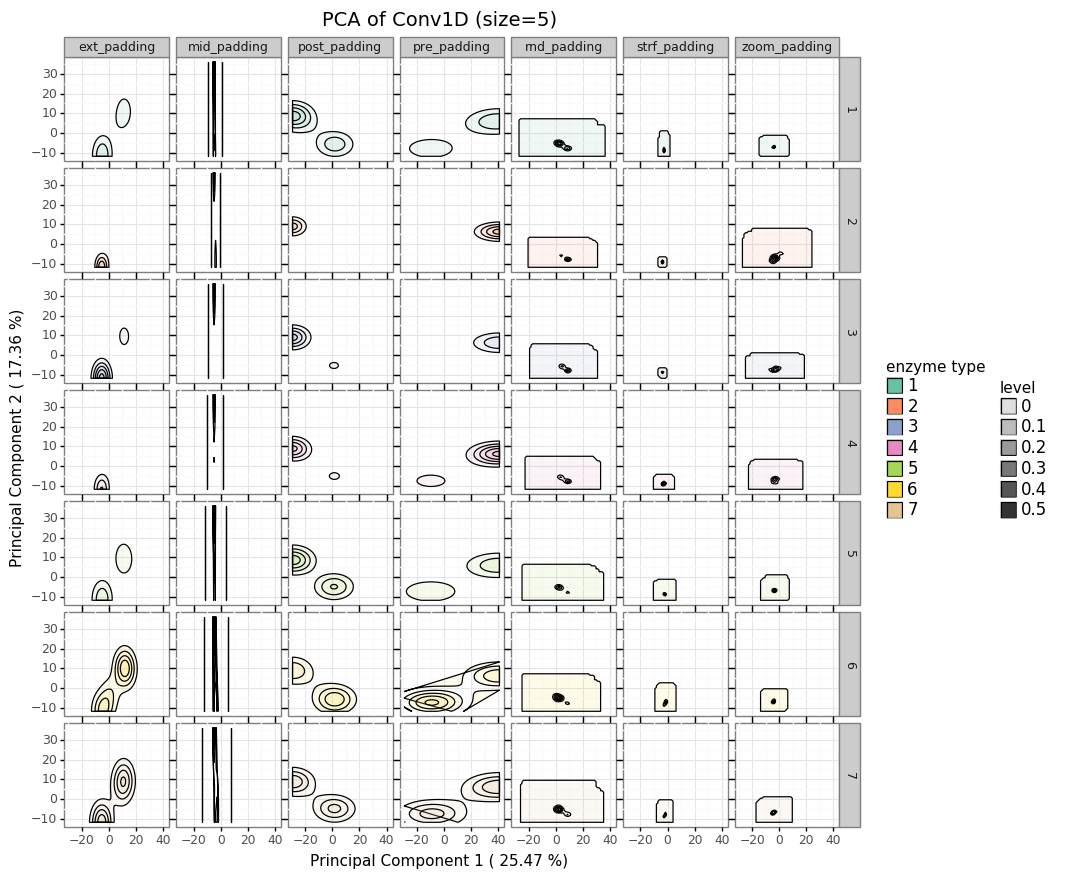

<ggplot: (-9223363284136408197)>

In [58]:
q = density_facet(final_df, pca)
saving_activations_plot("ggplot", "2protsPerType_densityFacet_1fold", folder, task, p=q)
q

## Task 1

In [59]:
task = "task1/"

In [ ]:
#Define list of dataframes
fold = 5
lista_dfs_task1 = []
for tup in prots_pca_task1:
    model_type = tup[2]
    enz_type = tup[1]
    prot = tup[0]
    #print("Model type: ", model_type, "enzyme type", enz_type)
    model = search_model(folder, str(fold), task, model_type)
    #writing log file 
    print('Model type: %s \n' % model_type)
    print('Enzyme type: %s \n' % enz_type)
    formatted_time = datetime.datetime.now()
    print('Starting time: %s \n' % formatted_time)
    activations = obtain_activations(model, nlayer, prot)
    act_df = activations_to_df(activations, model_type, fold)
    act_df["enzyme_type"] = tup[1]
    formatted_endtime = datetime.datetime.now()
    print('Finishing time: %s \n' % formatted_endtime)
    lista_dfs_task1.append(act_df)

Model type: ext_padding 

Enzyme type: 0 

Starting time: 2019-11-12 10:28:22.889622 

Finishing time: 2019-11-12 10:40:06.178143 

Model type: mid_padding 

Enzyme type: 0 

Starting time: 2019-11-12 10:40:06.211321 

Finishing time: 2019-11-12 10:51:49.498166 

Model type: post_padding 

Enzyme type: 0 

Starting time: 2019-11-12 10:51:49.536143 

Finishing time: 2019-11-12 11:03:27.593999 

Model type: pre_padding 

Enzyme type: 0 

Starting time: 2019-11-12 11:03:27.609714 

Finishing time: 2019-11-12 11:15:17.267079 

Model type: rnd_padding 

Enzyme type: 0 

Starting time: 2019-11-12 11:15:17.299219 

Finishing time: 2019-11-12 11:27:12.230363 

Model type: strf_padding 

Enzyme type: 0 

Starting time: 2019-11-12 11:27:12.252455 

Finishing time: 2019-11-12 11:39:20.404630 

Model type: zoom_padding 

Enzyme type: 0 

Starting time: 2019-11-12 11:39:20.420126 

Finishing time: 2019-11-12 11:51:32.558893 

Model type: ext_padding 

Enzyme type: 0 

Starting time: 2019-11-12 11:5

In [65]:
# ha tardado un huevo en ejecutarse asi que deberia guardarlo
filename = "activations_enzymeType_1fold.pickle"
pickle_path = "".join((absPath, "data/results/", folder, task, filename))

with open(pickle_path, 'wb') as handle:
    pickle.dump(lista_dfs_task1, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [66]:
final_df_task1, pca_task1 = train_pca(lista_dfs_task1, 2)

In [67]:
# guardamos final_df en un csv
filename = "pca_1fold.csv"
pickle_path = "".join((absPath, "data/results/", folder, task, filename))

#with open(pickle_path, 'wb') as handle:
#    pickle.dump(final_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

final_df_task1.to_csv(pickle_path)

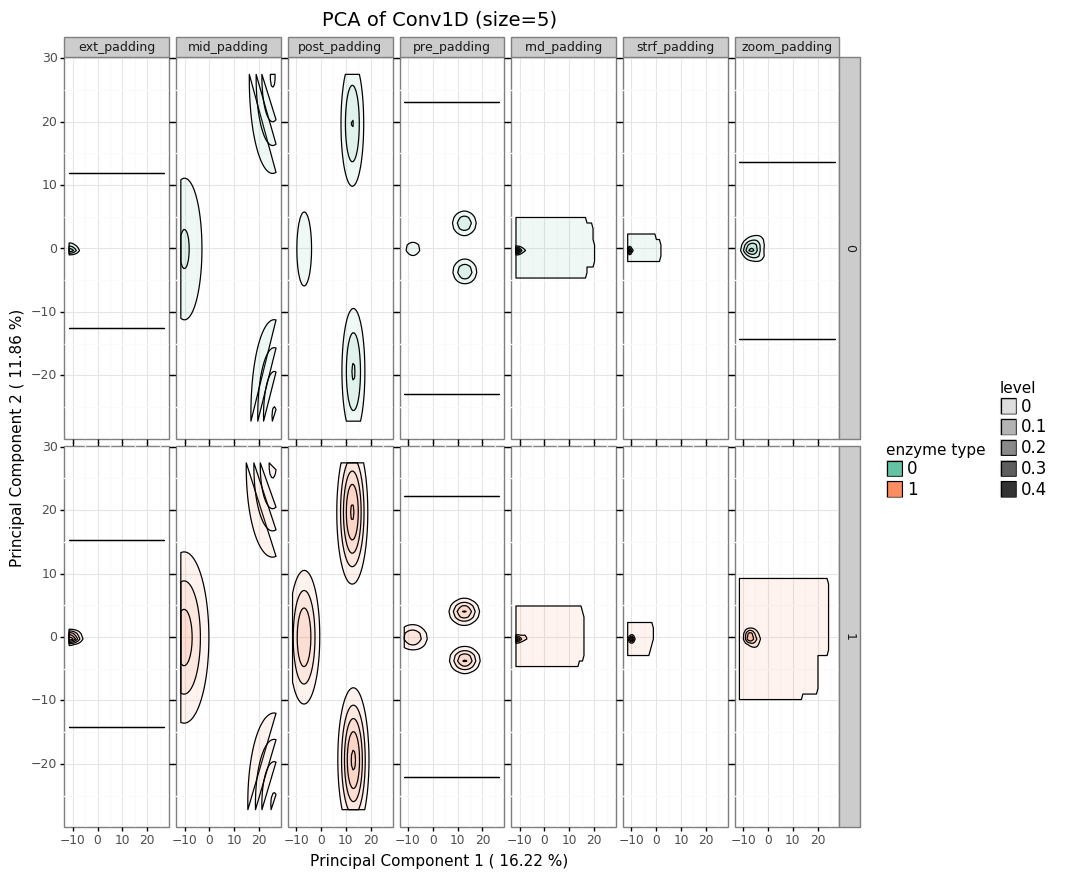

<ggplot: (-9223363284550675056)>

In [68]:
r = density_facet(final_df_task1, pca_task1)
saving_activations_plot("ggplot", "7protsPerType_densityFacet_1fold", folder, task, p=r)
r